In [6]:
import os
import sys
import pickle
import json
import pandas as pd
import numpy as np
from typing import Optional
from src.utils.databases import Database, Person, MailBasedDatabase
from src.main import load_main_db, get_userlist_file_from_dynamics, get_riegenlist_file_from_dynamics, path, ADULT_CAT, is_jugend_riege, get_riegen

In [101]:
userlist_file = get_userlist_file_from_dynamics(path)
riegenlist_file = get_riegenlist_file_from_dynamics(path)

ConnectionError: [ERROR] 2024/09/17 21:12:05 authorization prompt dismissed, please try again

In [7]:
userlist_file = 'MitgliederExportList_160924233320.xlsx'
riegenlist_file = 'OrgAdrList_1.01.02.5436.00-0_20240916_2333.csv'

In [8]:
main_db = load_main_db(path + userlist_file, path + riegenlist_file)

/Users/Lukas/Documents/Programming/Git/STVadmin_processing/.venv/lib/python3.12/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


In [9]:
with open("demo/temp_main_db_backup.pickle","wb") as f:
    pickle.dump(main_db, f)

In [10]:
helfer_df = pd.read_csv("demo/helper-assignments-2.csv", delimiter=";")

In [11]:
def nans_to_nones(row:pd.Series):
    new_row = pd.Series()
    for col in row.keys():
        if row[col] is None:
            new_row[col] = None
        if not isinstance(row[col], float):
            new_row[col] = row[col]
            continue
        if np.isnan(row[col]):
            new_row[col] = None
            continue
        new_row[col] = row[col]
    return new_row

def load_dates(row: pd.Series):
    new_row = pd.Series()
    for col in row.keys():
        if col in ["Datum", "Geburtsdatum"]:
            new_row[col] = pd.Timestamp(row[col])
            continue
        new_row[col] = row[col]
    return new_row        

In [12]:
helfer_df = helfer_df.apply(nans_to_nones, axis=1)
helfer_df = helfer_df.apply(load_dates, axis=1)

In [13]:
helfer_df

,Helfer:in,E-Mail,Telefon,Event,Aufgabe,Datum,Uhrzeit von,Uhrzeit bis,Stunden,Einsatzwert,Bemerkungen,Status,Bemerkung zum/zur Helfer:in,zusätzliche E-Mail (1),zusätzliche E-Mail (2),Geburtsdatum,geleistet für
0,Adrian Brönnimann,adi89-pedi91@hotmail.com,0797339037,Papiersammlung - Nachmittag,Papiersammler,2019-03-23,13:00,16:00,3.00,1.0,None,erschienen,None,None,None,1989-03-31,None
1,Adrian Brönnimann,adi89-pedi91@hotmail.com,0797339037,Papiersammlung - Nachmittag,Papiersammler,2022-03-19,13:00,17:00,4.00,1.0,None,erschienen,None,None,None,1989-03-31,None
2,Adrian Brönnimann,adi89-pedi91@hotmail.com,0797339037,Heimrunde Unihockey Herren I,Spielleitung/Zeitnehmer,2023-10-15,07:45,17:00,9.25,1.0,None,erschienen,None,None,None,1989-03-31,None
3,Adrian Brönnimann,adi89-pedi91@hotmail.com,0797339037,Papiersammlung,Papiersammler,2024-08-24,08:00,12:00,4.00,1.0,None,erschienen,None,None,None,1989-03-31,None
4,Agnes Sekinger,asekinger@gmail.com,079 321 39 25,"KUCHEN - Turnervorstellung 2019 - Cake, Torte,...",Kuchen/Torte backen,2019-11-23,10:00,12:30,2.50,1.0,None,erschienen,None,None,None,NaT,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1448,Werner Sekinger,werner.sekinger@sunrise.ch,078 781 40 34,Landsgemeinde der Aargauer Turnveteranenverein...,Aufstellen/Einrichten,2024-09-21,16:00,18:00,2.00,1.0,None,erschienen,None,None,None,1953-05-28,None
1449,Willi Koch,willikoch@bluewin.ch,079 372 17 45,Turnervorstellung 2019 - Festwirtschaft Spätsc...,Buffet,2019-11-23,23:00,01:00,2.00,1.0,23.00 - 01.00 Uhr,erschienen,None,None,None,1958-05-16,None
1450,Willi Koch,willikoch@bluewin.ch,079 372 17 45,"Turnervorstellung 2019 - Aufräumen/Abbau, Sonn...",Aufräumen,2019-11-24,10:00,13:00,3.00,1.0,None,erschienen,None,None,None,1958-05-16,None
1451,Willi Koch,willikoch@bluewin.ch,079 372 17 45,Landsgemeinde der Aargauer Turnveteranenverein...,Aufstellen/Einrichten,2024-09-21,16:00,18:00,2.00,1.0,None,erschienen,None,None,None,1958-05-16,None


In [14]:
helfer_df["member_number"] = None
helfer_df["is_kuchen"] = None

In [15]:
helfer_df = helfer_df.loc[helfer_df["Datum"]>= pd.Timestamp("2024")]

In [16]:
MINIMUM_AGE_TO_EXPECT_CHILDREN = 33

def find_person_in_db(row: pd.Series, main_db: Database):
    matching_email_people = main_db.lookup_by_property("email",row["E-Mail"])
    matching_email = only_member_numbers(matching_email_people)
    if len(matching_email) == 1:
        return matching_email[0]
    
    matching_name = get_list_matching_name(row["Helfer:in"], main_db)
    if len(matching_name) == 1:
        return matching_name[0]
    
    matching_beneficiary = get_list_matching_name(row["geleistet für"], main_db)
    if len(matching_beneficiary) ==1:
        return matching_beneficiary[0]
    
    matching_tel = get_list_matching_phone(row["Telefon"], main_db)
    if len(matching_tel) == 1:
        return matching_tel[0]
    
    if len(matching_email_people) >=1:
        for person in matching_email_people:
            if person.category in ADULT_CAT:
                return person.member_number
            
    last_name_match = match_child(row["Helfer:in"], row["Geburtsdatum"], main_db)
    if last_name_match is not None:
        return last_name_match
    return None
    
def get_list_matching_name(name:Optional[str], main_db: Database):
    if name is None:
        return []
    first_name = name.split(" ")[0]
    first_name = first_name[0].upper()+first_name[1:]
    last_name = name.split(" ")[-1]
    last_name = last_name[0].upper()+last_name[1:]
    matching_first_name = only_member_numbers(main_db.lookup_by_property("first_name", first_name))
    matching_last_name = only_member_numbers(main_db.lookup_by_property("last_name", last_name))

    matching_name = list(set(matching_first_name).intersection(set(matching_last_name)))
    return matching_name
    
def get_list_matching_phone(phone: Optional[str], main_db: Database):
    if phone is None:
        return []
    phone_formatted = phone.replace(" ", "")
    for prefix in ["41","+41","0041"]:
        if prefix == phone_formatted[:len(prefix)]:
            phone_formatted = "0" + phone_formatted[:len(prefix)]
    if phone_formatted[0] != 0:
        phone_formatted = "0"+phone_formatted
    
    matching = []
    for phone_property in ["phone_p", "phone_m", "phone_g"]:
        matching += (only_member_numbers(main_db.lookup_by_property(phone_property, phone_formatted)))
    return list(set(matching))

def match_child(name: Optional[str], dob:pd.Timestamp, main_db: Database):
    if name is None:
        return None
    
    age = calc_age(dob)
    if age < MINIMUM_AGE_TO_EXPECT_CHILDREN:
        return None
    
    last_name = name.split(" ")[-1]
    last_name = last_name[0].upper()+last_name[1:]
    matching_last_name = main_db.lookup_by_property("last_name", last_name)
    matching_last_name = [person for person in matching_last_name if person.category not in ADULT_CAT]

    if len(matching_last_name) == 0:
        return None

    person_match = None
    if len(matching_last_name) == 1:
        person_match = matching_last_name[0]
    else:
        addresses = []
        for person in matching_last_name:
            addresses.append(f"{person.street}, {person.plz}, {person.city}")
        if len(list(set(addresses)))==1:
            person_match = matching_last_name[0]
        else:
            print(list(set(addresses)))
    if person_match is None:
        return None
    print(f"ALERT: matching Helper {name} to Person {person_match.first_name} {person_match.last_name}")
    return person_match.member_number
    
def calc_age(dob: pd.Timestamp):
    ts = pd.Timestamp.now()
    age = ts.year - dob.year
    age -= (ts.month, ts.day) < (dob.month, dob.day)
    return age

def only_member_numbers(l: list[Person]):
    return [per.member_number for per in l]


In [17]:
helfer_df["member_number"] = helfer_df.apply(find_person_in_db,args=[main_db], axis=1).astype("Int64")


ALERT: matching Helper christine frunz to Person Laurin Frunz
ALERT: matching Helper christine frunz to Person Laurin Frunz
ALERT: matching Helper christine frunz to Person Laurin Frunz
['Narzissenweg 9, 5436, Würenlos', 'Ländliweg 19, 5436, Würenlos', 'Birchhof, 5436, Würenlos']
ALERT: matching Helper Elfriede Müller to Person Hannah Müller
['Ahornweg 4, 5436, Würenlos', 'Mattenstr. 3, 5436, Würenlos']
ALERT: matching Helper Erika Müller to Person Hannah Müller
['Ahornweg 4, 5436, Würenlos', 'Mattenstr. 3, 5436, Würenlos']
ALERT: matching Helper Florence Nordbeck to Person Anina Sophia Nordbeck
ALERT: matching Helper Heidi Oswald to Person Violet Oswald
ALERT: matching Helper Karin Thommen to Person Nino Thommen
ALERT: matching Helper Martin Fellmann to Person Jan Fellmann


/var/folders/42/9dh0v_k97hgcd048wt648jm00000gn/T/ipykernel_17332/680806139.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  helfer_df["member_number"] = helfer_df.apply(find_person_in_db,args=[main_db], axis=1).astype("Int64")


In [18]:
helfer_df.loc[np.isnan(helfer_df["member_number"])]

,Helfer:in,E-Mail,Telefon,Event,Aufgabe,Datum,Uhrzeit von,Uhrzeit bis,Stunden,Einsatzwert,Bemerkungen,Status,Bemerkung zum/zur Helfer:in,zusätzliche E-Mail (1),zusätzliche E-Mail (2),Geburtsdatum,geleistet für,member_number,is_kuchen


In [19]:
def is_kuchen(row:pd.Series):
    for anti_keyword in ["Buffet", "Küche"]:
        if anti_keyword.lower() in row["Aufgabe"].lower():
            return False
    for keyword in ["Kuchen", "Torte", "Backen", "Zopf", "Teigwarensalat", "Salat", "zubereiten"]:
        if keyword.lower() in row["Aufgabe"].lower():
            return True
    return False

In [20]:
kuchen = helfer_df.loc[helfer_df.apply(is_kuchen, axis=1)]
print(kuchen["Aufgabe"].unique())

['Kuchen/Torte backen' 'Kuchen backen']


In [21]:
not_kuchen = helfer_df.loc[~helfer_df.apply(is_kuchen, axis=1)]
print(not_kuchen["Aufgabe"].unique())

['Papiersammler' 'Aufstellen/Einrichten' 'Festwirtschaft' 'Service'
 'Buffet/Abwasch' 'Grill' 'Kiosk' 'Spielleitung/Zeitnehmer' 'Kuchenbuffet'
 'Betreuung Posten Wassertragen' 'T-Shirt Ausgabe' 'Aufräumen'
 'Plätze vorbereiten' 'OK' 'Schokolade verteilen' 'Küche'
 'Festwirtschaft Gmeindschäller'
 'Aufstellen Schmierseifenbahn / Lauf / Diverses'
 'Betreuung Posten Schmierseifenbahn' 'Buffet' 'Betreuung Posten Biathlon'
 'Eingangskasse' 'Anmeldung' 'Getränkebuffet' 'Betreuung Lauf 60/80m'
 'Kuchen- & Getränkebuffet' 'Verkehrsdienst' 'Kasse' 'Läufer' 'Apéro'
 'Siegerehrung' 'Betreuung Rangverlesen' 'Ehrenmitgliederapéro'
 'Ausschank Apéro' 'Standblattausgabe / Anmeldung' 'Springer'
 'chef de service' 'Aufbau' 'Ehrendame/Ehrenherr'
 'Betreuung Posten Unihockeyparcours' 'Betreuung Posten 4x4' 'Speaker'
 'Spielleitung']


In [22]:
helfer_df["is_kuchen"] = helfer_df.apply(is_kuchen, axis=1)

/var/folders/42/9dh0v_k97hgcd048wt648jm00000gn/T/ipykernel_17332/3678191663.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  helfer_df["is_kuchen"] = helfer_df.apply(is_kuchen, axis=1)


In [23]:
helfer_df

,Helfer:in,E-Mail,Telefon,Event,Aufgabe,Datum,Uhrzeit von,Uhrzeit bis,Stunden,Einsatzwert,Bemerkungen,Status,Bemerkung zum/zur Helfer:in,zusätzliche E-Mail (1),zusätzliche E-Mail (2),Geburtsdatum,geleistet für,member_number,is_kuchen
3,Adrian Brönnimann,adi89-pedi91@hotmail.com,0797339037,Papiersammlung,Papiersammler,2024-08-24,08:00,12:00,4.0,1.0,None,erschienen,None,None,None,1989-03-31,None,871317,False
11,Alena Vicha,claudiawanner@bluewin.ch,076 584 81 19,Plauscholympiade | Kuchen/Torte backen,Kuchen/Torte backen,2024-04-05,12:00,13:00,1.0,1.0,None,erschienen,None,None,None,2013-09-24,None,3047570,True
18,Alexander Indermaur,doris.indermaur@gmx.ch,076 580 59 74,Sommergrillplausch | Kuchen backen,Kuchen backen,2024-02-07,16:00,23:00,7.0,1.0,None,erschienen,None,None,None,2012-07-04,None,3114393,True
23,Alfred Koller,alfred.koller@tbwnet.ch,079 574 43 56,Landsgemeinde der Aargauer Turnveteranenverein...,Aufstellen/Einrichten,2024-09-21,16:00,18:00,2.0,1.0,None,erschienen,None,None,None,1943-08-10,None,871329,False
25,Alfred Markwalder,alfred.markwalder@gmail.com,079 710 44 74,Kant. Finalspieltag Faustball,Festwirtschaft,2024-08-31,08:30,13:30,5.0,1.0,None,erschienen,None,None,None,1948-07-04,None,178830,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1445,Vreni Städler,vreni@staedi.ch,079 501 66 52,"Coop ""Tag der guten Tat""",Schokolade verteilen,2024-05-25,17:00,20:00,3.0,1.0,None,erschienen,None,None,None,1959-09-01,None,871515,False
1446,Walter Kessler,walter.kessler@bluewin.ch,0793779062,Landsgemeinde der Aargauer Turnveteranenverein...,Aufstellen/Einrichten,2024-09-21,16:00,18:00,2.0,1.0,None,erschienen,None,None,None,1949-03-05,None,178827,False
1447,Werner Frauenfelder,werner.frauenfelder@tbwnet.ch,None,Landsgemeinde der Aargauer Turnveteranenverein...,Aufstellen/Einrichten,2024-09-21,16:00,18:00,2.0,1.0,None,erschienen,None,None,None,1950-07-12,None,398887,False
1448,Werner Sekinger,werner.sekinger@sunrise.ch,078 781 40 34,Landsgemeinde der Aargauer Turnveteranenverein...,Aufstellen/Einrichten,2024-09-21,16:00,18:00,2.0,1.0,None,erschienen,None,None,None,1953-05-28,None,146153,False


In [24]:
from pyvis.network import Network
import matplotlib as mpl
import matplotlib.pyplot as plt

In [25]:
def create_helper_network(main_db: Database, helper_df: pd.DataFrame):
    net = Network(notebook=False, width="100%", height="100%")
    net = add_riegen_nodes(net, main_db=main_db)
    net = add_member_nodes(net, main_db=main_db, helper_df=helper_df)
    return net

def add_riegen_nodes(net: Network, main_db: Database):
    for riege in main_db.riegen:
        if is_jugend_riege(riege):
            continue
        net.add_node(n_id=riege, label=riege, group="riege", shape="circle")
    return net

def add_member_nodes(net: Network, main_db: Database, helper_df: pd.DataFrame):
    max_num_of_jobs = get_max_num_of_jobs(helper_df)
    cmap = mpl.cm.get_cmap("Reds")
    norm = mpl.colors.Normalize(vmin=0, vmax=max_num_of_jobs*10)
    for person in main_db.people:
        if person.category not in ADULT_CAT:
            continue
        num_of_jobs = get_num_of_jobs(person, helper_df)
        hex_col = mpl.colors.rgb2hex(cmap(norm(num_of_jobs*10)))
        net.add_node(n_id=person.member_number, 
                     label=str(num_of_jobs), 
                     #group="person", 
                     shape="dot", 
                     title=f"{person.first_name} {person.last_name}", 
                     value=int(np.log(num_of_jobs+1)*1000),
                     x=100 if person.gender=="Weiblich" else -100,
                     color=hex_col)
        for riege in set(person.riegen_member + person.riegen_coach):
            if is_jugend_riege(riege):
                continue
            net.add_edge(person.member_number, riege)
    return net

def get_num_of_jobs(person: Person, helper_df: pd.DataFrame):
    num_of_jobs = len(helper_df.loc[helper_df["member_number"] == person.member_number])
    return num_of_jobs

def get_max_num_of_jobs(helper_df: pd.DataFrame):
    #ToDo: do properly
    return 13

In [26]:
def ohne_kuchen(df:pd.DataFrame):
    return df.loc[df["is_kuchen"]==False]

In [27]:
net = create_helper_network(main_db=main_db, helper_df=helfer_df)
net.show("HelperNetwork.html",notebook=False)

/var/folders/42/9dh0v_k97hgcd048wt648jm00000gn/T/ipykernel_17332/1305484528.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = mpl.cm.get_cmap("Reds")


HelperNetwork.html


In [28]:
net = create_helper_network(main_db=main_db, helper_df=ohne_kuchen(helfer_df))
net.show("HelperNetworkNoKuchen.html",notebook=False)

/var/folders/42/9dh0v_k97hgcd048wt648jm00000gn/T/ipykernel_17332/1305484528.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = mpl.cm.get_cmap("Reds")


HelperNetworkNoKuchen.html


In [29]:
def barchart_per_alter(main_db:Database, helper_df: pd.DataFrame, title:str):
    age_min = 15
    age_max = 80
    years_per_window = 5
    age_windows = range(age_min,age_max, years_per_window)
    y_per_window = [num_of_jobs_in_age_window(helper_df, main_db, age, age+years_per_window) for age in age_windows]
    plt.boxplot(y_per_window, positions=age_windows)
    plt.title(title)
    plt.show()
    
def num_of_jobs_in_age_window(helper_df:pd.DataFrame, main_db: Database, age_begin:int, age_end:int):
    res = []
    for person in main_db.people:
        if age_begin<=person.age<age_end:
            res.append(get_num_of_jobs(person, helper_df))
    return res

def barchart_per_riege(main_db:Database, helper_df: pd.DataFrame, title:str):
    erw_riegen = [riege for riege in main_db.riegen if not is_jugend_riege(riege)]
    y_per_riege = [num_of_jobs_for_riege(helper_df, main_db, riege) for riege in erw_riegen]
    plt.boxplot(y_per_riege)
    plt.title(title)
    plt.xticks(range(len(erw_riegen)), erw_riegen,rotation=70)
    plt.show()

def num_of_jobs_for_riege(helper_df:pd.DataFrame, main_db: Database, riege:str):
    res = []
    for person in main_db.people:
        if riege in person.riegen_member or riege in person.riegen_coach:
            res.append(get_num_of_jobs(person, helper_df))
    return res

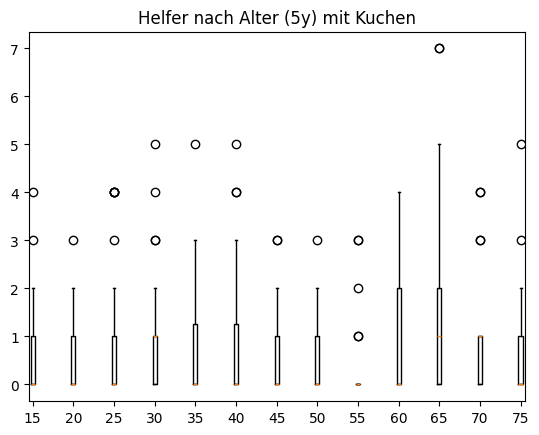

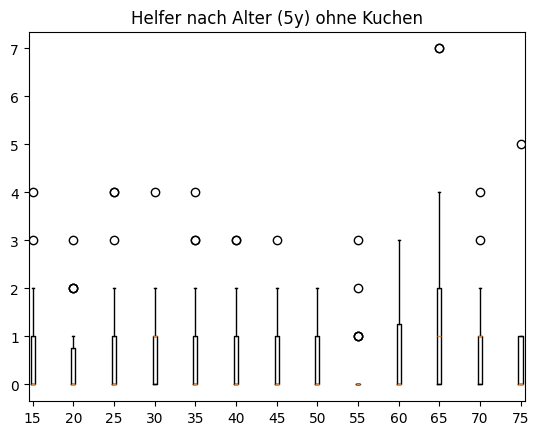

In [30]:
barchart_per_alter(main_db=main_db,helper_df=helfer_df, title="Helfer nach Alter (5y) mit Kuchen")
barchart_per_alter(main_db=main_db,helper_df=ohne_kuchen(helfer_df), title="Helfer nach Alter (5y) ohne Kuchen")

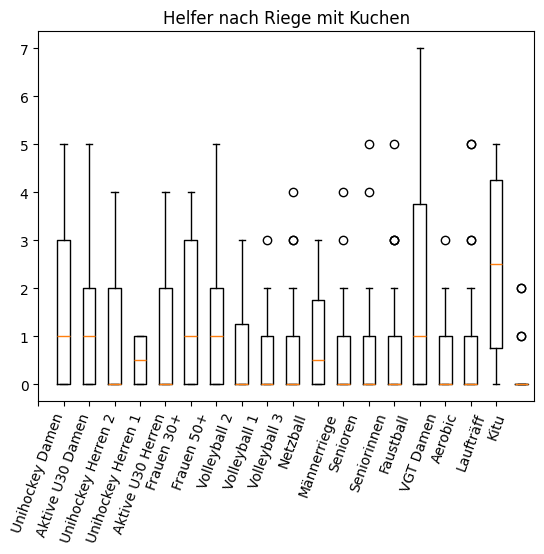

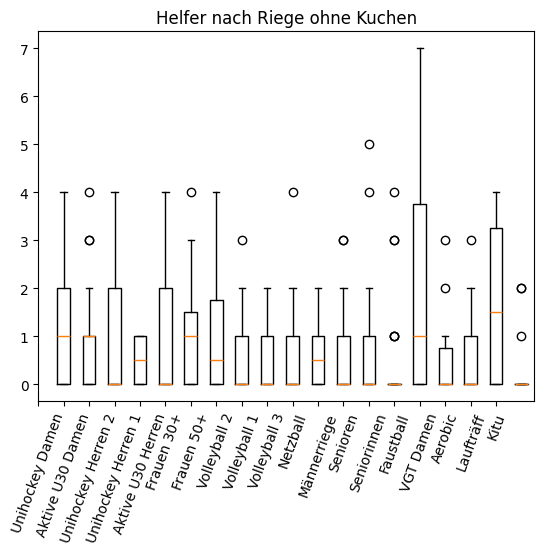

In [31]:
barchart_per_riege(main_db=main_db,helper_df=helfer_df, title="Helfer nach Riege mit Kuchen")
barchart_per_riege(main_db=main_db,helper_df=ohne_kuchen(helfer_df), title="Helfer nach Riege ohne Kuchen")

In [32]:
num_of_jobs_for_riege(ohne_kuchen(helfer_df), main_db, "Aerobic")

[0, 1, 1, 0, 0, 2, 1, 0, 2, 0, 0, 0, 3, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0]

In [28]:
helfer_df.loc[helfer_df["Helfer:in"]=="Kim Stocker"]

,Helfer:in,E-Mail,Telefon,Event,Aufgabe,Datum,Uhrzeit von,Uhrzeit bis,Stunden,Einsatzwert,Bemerkungen,Status,Bemerkung zum/zur Helfer:in,zusätzliche E-Mail (1),zusätzliche E-Mail (2),Geburtsdatum,geleistet für,member_number,is_kuchen
